In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import multiprocessing as mp
import rasterio

from pathlib import Path
from rasterio.plot import show

%matplotlib inline

In [2]:
data_path = Path('.').resolve().parent / "data"

In [3]:
urban_network_old = gpd.read_file(data_path / 'Oteiza' / 'urban_network' / 'Calles Plan.shp')
urban_network_old.head()

,OBJECTID_1,OBJECTID,Shape_Leng,Shape_Le_1,Shape_Area,geometry
0,1,1,127162.803192,119043.942613,792534.410363,"MULTIPOLYGON (((256237.120 6340931.603, 256233..."


In [4]:
shelter_locations = gpd.read_file(data_path  / 'Oteiza' / 'shelter_locations' / 'P_E.shp')
shelter_locations.head()

,Id,x,y,Nu_PE,geometry
0,0,254233.0,6341020.0,2.0,POINT (254233.439 6341019.395)
1,0,254524.0,6341010.0,3.0,POINT (254523.816 6341014.674)
2,0,254668.0,6340820.0,4.0,POINT (254668.452 6340823.254)
3,0,254762.0,6340610.0,5.0,POINT (254762.334 6340608.970)
4,0,254941.0,6340360.0,6.0,POINT (254941.376 6340360.074)


## Urban Network

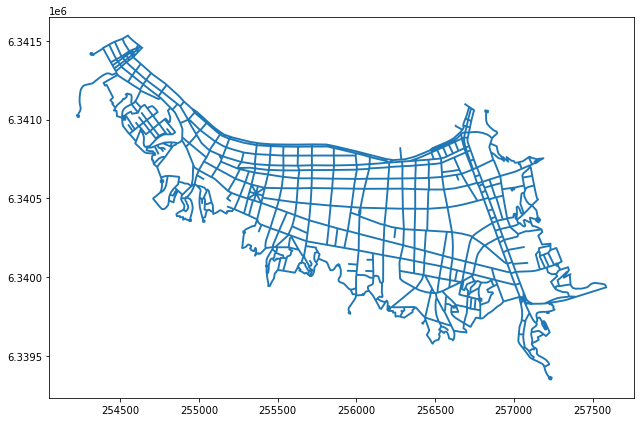

In [5]:
fig, ax = plt.subplots(figsize=(12, 7))
urban_network_old.plot(ax=ax)
fig.show()

In [6]:
urban_area = urban_network_old.to_crs('epsg:4326').convex_hull.iloc[0]
G = ox.graph_from_polygon(
    urban_area,
    network_type='walk',
    simplify=False
)
G = ox.project_graph(G, to_crs='epsg:32719')
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

### Shorter path

In [7]:
def euclidean_dist(a, b, G=G):
    x1 = G.nodes[a]['x']
    y1 = G.nodes[a]['y']
    x2 = G.nodes[b]['x']
    y2 =  G.nodes[b]['y']
    return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5


def best_astar_path(G, source, targets, heuristic=None, weight='weight'):
    paths = {target: nx.astar_path(G, source, target, heuristic, weight) for target in targets}
    lengths = {target: sum(ox.utils_graph.get_route_edge_attributes(G, path, weight)) for target, path in paths.items()}
    best_target = min(lengths, key=lengths.get)
    return (source, best_target, lengths[best_target], paths[best_target])

In [8]:
shelter_nodes = ox.distance.nearest_nodes(
    G,
    X=shelter_locations['x'].values,
    Y=shelter_locations['y'].values
)


In [9]:
cpus = None
args = ((G, origin, shelter_nodes, euclidean_dist, 'length') for origin in G.nodes)
pool = mp.Pool(cpus)
sma = pool.starmap_async(best_astar_path, args)
paths = sma.get()
pool.close()
pool.join()

In [10]:
path_df = pd.DataFrame(paths, columns=['osmid', 'shelter_osmid', 'cost', 'route_list'])
path_df['route'] = path_df['route_list'].apply(lambda route: '&'.join(str(x) for x in route))
path_df.head()

,osmid,shelter_osmid,cost,route_list,route
0,255384937,277652486,290.405,"[255384937, 255385018, 255385079, 256618477, 2...",255384937&255385018&255385079&256618477&256618...
1,256617916,277652486,309.987,"[256617916, 255384937, 255385018, 255385079, 2...",256617916&255384937&255385018&255385079&256618...
2,255385018,277652486,270.158,"[255385018, 255385079, 256618477, 256618479, 2...",255385018&255385079&256618477&256618479&256618...
3,255384941,277652486,169.373,"[255384941, 255385312, 5309709056, 4781992891,...",255384941&255385312&5309709056&4781992891&5309...
4,255790084,277652486,202.320,"[255790084, 255384941, 255385312, 5309709056, ...",255790084&255384941&255385312&5309709056&47819...


In [11]:
G_undirected = ox.utils_graph.get_undirected(G)
nodes_undirected, edges_undirected = ox.graph_to_gdfs(G_undirected, nodes=True, edges=True)

In [12]:
netlogo_nodes = (
    nodes.reset_index()
    .merge(
        path_df.drop(columns='route_list'),
        on='osmid'
    )
    .rename(columns={"osmid": "id", "shelter_osmid": "shelter_id"})
    .loc[: ,["id", "x", "y", "shelter_id", "route", "geometry"]]
)
netlogo_nodes.head()

,id,x,y,shelter_id,route,geometry
0,255384937,254722.232910,6.341039e+06,277652486,255384937&255385018&255385079&256618477&256618...,POINT (254722.233 6341038.898)
1,256617916,254738.523120,6.341050e+06,277652486,256617916&255384937&255385018&255385079&256618...,POINT (254738.523 6341049.804)
2,255385018,254706.146387,6.341027e+06,277652486,255385018&255385079&256618477&256618479&256618...,POINT (254706.146 6341026.576)
3,255384941,254515.666868,6.340880e+06,277652486,255384941&255385312&5309709056&4781992891&5309...,POINT (254515.667 6340879.680)
4,255790084,254490.621028,6.340858e+06,277652486,255790084&255384941&255385312&5309709056&47819...,POINT (254490.621 6340858.245)


In [13]:
urban_network = (
    edges_undirected.reset_index()
    .rename(
        columns={
            "osmid": "id",
            "from": "from_id",
            "to": "to_id",
        }
    )
    .assign(weight=lambda x: x["length"])
    .loc[
        :,
        [
            "id",
            "from_id",
            "to_id",
            "weight",
            "length",
            "highway",
            "lanes",
            "geometry"

        ]
    ]
)
urban_network.head()

,id,from_id,to_id,weight,length,highway,lanes,geometry
0,23583548,256617916,255384937,19.582,19.582,pedestrian,NaN,"LINESTRING (254738.523 6341049.804, 254722.233..."
1,23699663,255385018,255384937,20.247,20.247,residential,2,"LINESTRING (254706.146 6341026.576, 254722.233..."
2,23583548,1489764754,256617916,11.938,11.938,pedestrian,NaN,"LINESTRING (254731.138 6341059.174, 254738.523..."
3,23583561,255385016,255385018,64.707,64.707,residential,2,"LINESTRING (254744.298 6340974.372, 254706.146..."
4,386734913,255385052,255385018,46.275,46.275,residential,2,"LINESTRING (254669.408 6340998.379, 254706.146..."


In [14]:
netlogo_nodes.to_file(data_path / 'urban_network'/ "nodes.shp")
urban_network.to_file(data_path / 'urban_network'/ "urban_network.shp")

In [15]:
netlogo_nodes.query("id == 2251233874").iloc[0].route.split("&")

['2251233874',
 '4792360858',
 '2251233620',
 '4792360853',
 '3740238648',
 '3740238700',
 '3740238703',
 '3740238658',
 '5016512864',
 '3629947459',
 '3629947460',
 '3629948716',
 '3629947461',
 '3629947462',
 '3629947463',
 '3629947464',
 '3740238659',
 '4757436318',
 '4258753731',
 '4757436321',
 '3629947465',
 '264676817',
 '5309254587',
 '5309254586',
 '5309254585',
 '5309254584',
 '255790595',
 '262546955',
 '257666388',
 '262528952',
 '255790597',
 '259211943',
 '259211942',
 '5316795638',
 '5316795698',
 '259659648',
 '4790602513',
 '4790602512',
 '4790602511',
 '259659652',
 '4790602510',
 '4790602514',
 '4790602509',
 '3393372826',
 '259659654',
 '4790602518',
 '4790602516',
 '259659655',
 '6013560399',
 '4790602519',
 '259659659',
 '312662504',
 '5337129466',
 '4790602520',
 '5337129467',
 '2452360009',
 '259659662',
 '291963800']

In [16]:
[2251233874 4792360858 2251233620 4792360853 3740238648 3740238700 3740238703 3740238658 5016512864 3629947459 3629947460 3629948716 3629947461 3629947462 3629947463 3629947464 3740238659 4757436318 4258753731 4757436321 3629947465 264676817 5309254587 53]

SyntaxError: invalid syntax (3754891730.py, line 1)

## Shelters

In [ ]:
netlogo_shelters = (
    netlogo_nodes.loc[lambda x: x["id"].isin(shelter_nodes)]
    .assign(evac_type="horizontal")
    .loc[
        :,
        ["id", "x", "y", "evac_type", "geometry"]
    ]
)
netlogo_shelters.head()

,id,x,y,evac_type,geometry
450,257688522,254668.451930,6.340823e+06,horizontal,POINT (254668.452 6340823.254)
593,291963800,256829.119069,6.341054e+06,horizontal,POINT (256829.119 6341053.937)
1032,5718043491,255288.033138,6.340285e+06,horizontal,POINT (255288.033 6340285.170)
1074,262556761,255886.409702,6.340075e+06,horizontal,POINT (255886.410 6340074.916)
1258,276565012,254763.881319,6.340600e+06,horizontal,POINT (254763.881 6340599.857)


In [ ]:
# shelters = (
#     shelter_locations
#     .rename(columns={"Id": "id"})
#     .assign(type="horizontal")
#     .loc[
#         :,
#         ["id", ""]
#     ]
# )
# shelters.head()

In [ ]:
netlogo_shelters.to_file(data_path / 'shelters'/ "shelters.shp")

## Agent Distribution

In [ ]:
population_distribution_old = gpd.read_file(data_path / "Oteiza" / "population_distribution" / "u_3_Diurno.shp")
population_distribution_old.head()

,Agente,XUTM19S,YUTM19S,Velocidad,td,geometry
0,1,255187.17,6340450.5,1.57,208.120620,POINT (255187.170 6340450.500)
1,2,255007.17,6340468.5,1.54,351.581240,POINT (255007.170 6340468.500)
2,3,255073.17,6340804.5,1.34,24.198232,POINT (255073.170 6340804.500)
3,4,255937.17,6339946.5,1.53,106.649740,POINT (255937.170 6339946.500)
4,5,255415.17,6340330.5,1.50,199.641320,POINT (255415.170 6340330.500)


In [ ]:
netlogo_population_distribution = (
    population_distribution_old.rename(
        columns={
            "Agente": "id",
            "Velocidad": "speed",
            "td": "depar_time",
        }
    )
    .assign(age=99)
    .loc[
        :,
        ["id", "age", "depar_time", "speed", "geometry"]
    ]
)
netlogo_population_distribution.head()

,id,age,depar_time,speed,geometry
0,1,99,208.120620,1.57,POINT (255187.170 6340450.500)
1,2,99,351.581240,1.54,POINT (255007.170 6340468.500)
2,3,99,24.198232,1.34,POINT (255073.170 6340804.500)
3,4,99,106.649740,1.53,POINT (255937.170 6339946.500)
4,5,99,199.641320,1.50,POINT (255415.170 6340330.500)


In [ ]:
netlogo_population_distribution.to_file(data_path / 'agent_distribution'/ "agent_distribution.shp")

## Tsunami

In [ ]:
tsunami_inundatation = rasterio.open(data_path  / 'tsunami_inundation'/ 'sample.asc')

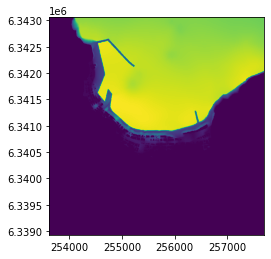

<AxesSubplot:>

In [ ]:
show((tsunami_inundatation, 1))